In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']
experiment_ids1 = ['historical']

# Seasons to process
seasons = ['DJF','JJA']

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])


In [3]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [4]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [5]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [6]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [7]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [8]:
# Get names of all the models in the subset
df_areacella = (df[((df.table_id == 'fx') 
                 & (df.variable_id == 'areacella')
                 & (df.member_id == "r1i1p1f1"))])

areacella_source_ids = []
for name, group in df_areacella.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids1]):
        areacella_source_ids.append(name)
areacella_source_ids

['CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'E3SM-1-0',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON']

In [9]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [11]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))
source_ids

['BCC-ESM1',
 'CESM2-WACCM',
 'CanESM5',
 'MRI-ESM2-0',
 'MIROC6',
 'CAMS-CSM1-0',
 'BCC-CSM2-MR',
 'IPSL-CM6A-LR',
 'CESM2']

In [12]:
source_ids_areacella=list(set(tas_source_ids).intersection(pr_source_ids).intersection(areacella_source_ids))
source_ids_areacella

['CESM2-WACCM', 'CanESM5', 'MRI-ESM2-0', 'MIROC6', 'IPSL-CM6A-LR', 'CESM2']

In [13]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [14]:
def spatial_average(field,lat_or_spatial_weights,latitude):
    if lat_or_spatial_weights is not None:
        field_mean = np.average(field,weights=lat_or_spatial_weights.areacella)
    else:
        # Use the cosine of the converted latitudes as weights for the average
        field_mean = np.average(field.mean("lon"),weights=np.cos(np.deg2rad(latitude)))
    return field_mean

In [15]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp, weights_in=None):

    # Load
    data_tmp['hist'].load()
    data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].tas.mean('time'))
    mu_futr = (data_tmp['futr'].tas.mean('time'))

    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)
        
    dtasG = mu_futrG-mu_histG

    return(dtasG)

In [17]:
tdata = {}

times = []
for mod_name in tqdm(source_ids):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])
    ds_alldata = xr.concat([ds_hist,ds_ssp],"time")


    try: # try getting areacella data
        ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    tdata[mod_name] = {}

    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_alldata.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_alldata.time.max().dt.year.values))
            break

        # Get corresponding temporal slice of data and stage it
        ds_futr_tmp = ds_alldata.sel(time=slice(time_slice[0],time_slice[1]))
        tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_futr_tmp}


        dtasG = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]], weights_in=ds_areacella)

        times.append(xr.Dataset( {mod_name: ([ 'time'],  np.atleast_1d(dtasG))},
                          coords = { 'time': ('time',[int(time_slice[0])])}))

        print(' processed!')

        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')





Starting BCC-ESM1

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
Future time series only goes until 2055
BCC-ESM1 processed!


Starting CESM2-WACCM

Begin processing time slice 1991-2020


KeyboardInterrupt: 

In [18]:
temp_da = xr.combine_by_coords(times)


In [19]:
temp_da.to_dataframe()

,BCC-ESM1
time,
1991,0.393608
2001,0.829522
2011,1.080176
2021,1.282089


In [27]:
temp_da.to_dataframe().to_csv('tresults.csv')

In [28]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,BCC-CSM2-MR,BCC-ESM1,CAMS-CSM1-0,CESM2,CESM2-WACCM,CanESM5,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
time,,,,,,,,,,
1991,0.263131,0.393605,0.148219,0.309265,0.338959,0.394012,0.248474,0.291992,0.162506,0.314636
2001,0.681881,0.829525,0.428157,0.791779,0.779694,1.012848,0.610657,0.695160,0.479370,0.763702
2011,0.964405,1.080178,0.585576,1.094421,1.007812,1.438416,0.812866,1.021454,0.697571,1.023926
2021,1.241889,1.282091,0.772981,1.337646,1.271332,1.863525,1.021637,1.346252,0.924072,1.267822
2031,1.599642,NaN,0.993941,1.657044,1.642242,2.394562,1.295197,1.789947,1.235840,1.614258
2041,1.969406,NaN,1.272330,2.027405,2.098663,2.996094,1.631073,2.248840,1.533264,1.980377
2051,2.325532,NaN,1.531311,2.485107,2.548523,3.578979,2.001831,2.722992,1.861328,2.343811
2061,2.711011,NaN,1.834118,3.025238,3.027191,4.184479,2.398163,3.222717,2.143311,2.689728
2071,3.085562,NaN,2.101575,3.541107,3.494812,4.786499,2.761658,3.826843,2.475281,3.042175


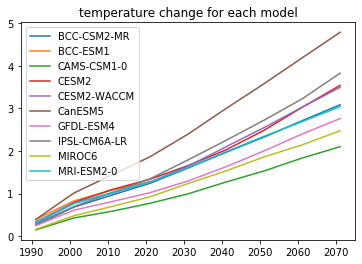

In [29]:
plt.plot(tresults_new)
plt.title('temperature change for each model')
plt.legend(tresults_new.columns)

In [30]:
# PRECIP

In [33]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    # Set if season is 'all'
    #if seas=="all":
    #    seas = ['DJF','MAM','JJA','SON']
    
    # Load
    data_tmp['hist'].load()
    data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)

    # Calculate standard deviation of detrended series
    # data[mod_name]['t'+time_slice[0]]['hist']
    if seas == "DJF":
        middle_month = 1
    elif seas == "JJA":
        middle_month = 7

    rollingmean = data_tmp['hist']['pr'].sel(time=data_tmp['hist'].time.dt.season.isin(seas)).rolling(time=3,min_periods=3,center=True).mean()
    timeseries_of_seasonalmeans = rollingmean.sel(time=rollingmean.time.dt.month.isin(middle_month))
    sd_hist = xr.apply_ufunc(signal.detrend, timeseries_of_seasonalmeans.dropna('time'),kwargs={'axis': timeseries_of_seasonalmeans.dims.index('time')}).std("time")

    rollingmean = data_tmp['futr']['pr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas)).rolling(time=3,min_periods=3,center=True).mean()
    timeseries_of_seasonalmeans = rollingmean.sel(time=rollingmean.time.dt.month.isin(middle_month))
    sd_futr = xr.apply_ufunc(signal.detrend, timeseries_of_seasonalmeans.dropna('time'),kwargs={'axis': timeseries_of_seasonalmeans.dims.index('time')}).std("time")
    
    
    # Take the spatial average of variance
    # Calculate variance
    var_hist = sd_hist ** 2    
    var_histG = spatial_average(var_hist,weights_in,latitude)
    sd_histG = np.sqrt(var_histG)

    var_futr = sd_futr ** 2
    var_futrG = spatial_average(var_futr,weights_in,latitude)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
    dsdG = sd_futrG/sd_histG

    dmuG = xr.DataArray(dmuG, coords=[], dims=[]).rename('dmuG')
    dsdG = xr.DataArray(dsdG, coords=[], dims=[]).rename('dsdG')
    
    return(dmuG,dsdG)


In [34]:
data = {}
models = []

for mod_name in tqdm(source_ids):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
    ds_alldata = xr.concat([ds_hist,ds_ssp],"time")

    try: # try getting areacella data
        ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    data[mod_name] = {}

    times = []
    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_alldata.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_alldata.time.max().dt.year.values))
            break

       # Get corresponding temporal slice of data and stage it
        ds_futr_tmp = ds_alldata.sel(time=slice(time_slice[0],time_slice[1]))
        data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_futr_tmp}



        seasons_loop = []
        for seas in seasons:
            # Calculate means, sds,...
            dmuG , dsdG = mean_var_calc(data[mod_name]['t'+time_slice[0]],seas, weights_in = ds_areacella)
            # concatenate dataarrays
            # I will have to keep the mu_hist, mu_futr, sd_hist, sd_futr
            # out because they can have different lat and lon
#                 das = [mu_hist.rename('mu_hist'),
#                        mu_futr.rename('mu_futr'),
#                        dmuG,
#                        sd_hist.rename('sd_hist'), 
#                        sd_futr.rename('sd_futr'), dsdG]
            das = [dmuG, dsdG]
            das_expanded = [da.expand_dims(['model_name', 'time', 'season']) for da in das]
            dasb = xr.merge(das_expanded)
            dasb.coords['model_name'] = 'model_name', [mod_name]
            dasb.coords['time'] = 'time', [int(time_slice[0])]
            dasb.coords['season'] = 'season', [seas]
            seasons_loop.append(dasb)
            #print(seas+' processed!')
        times.append(seasons_loop)    
        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')
    models.append(times)




Starting CESM2

Begin processing time slice 1991-2020
1991-2020 processed!
Begin processing time slice 2001-2030
2001-2030 processed!
Begin processing time slice 2011-2040
2011-2040 processed!
Begin processing time slice 2021-2050
2021-2050 processed!
Begin processing time slice 2031-2060
2031-2060 processed!
Begin processing time slice 2041-2070
2041-2070 processed!
Begin processing time slice 2051-2080
2051-2080 processed!
Begin processing time slice 2061-2090
2061-2090 processed!
Begin processing time slice 2071-2100
2071-2100 processed!
CESM2 processed!


Starting GFDL-ESM4

Begin processing time slice 1991-2020
1991-2020 processed!
Begin processing time slice 2001-2030
2001-2030 processed!
Begin processing time slice 2011-2040
2011-2040 processed!
Begin processing time slice 2021-2050
2021-2050 processed!
Begin processing time slice 2031-2060
2031-2060 processed!
Begin processing time slice 2041-2070
2041-2070 processed!
Begin processing time slice 2051-2080
2051-2080 processed!

In [35]:
outer_loop = []
for outer in models:
    inner_loop = []
    for inner in outer:
        a = xr.concat(inner, dim='season')
        inner_loop.append(a)
    b = xr.concat(inner_loop, dim='time')
    outer_loop.append(b)
temp_dapr = xr.concat(outer_loop, dim='model_name')
temp_dapr

<xarray.Dataset>
Dimensions:     (model_name: 10, season: 2, time: 9)
Coordinates:
  * time        (time) int64 1991 2001 2011 2021 2031 2041 2051 2061 2071
  * season      (season) object 'DJF' 'JJA'
  * model_name  (model_name) object 'CESM2' 'GFDL-ESM4' ... 'MRI-ESM2-0'
Data variables:
    dmuG        (model_name, time, season) float64 1.003 1.002 ... 1.051 1.053
    dsdG        (model_name, time, season) float64 1.027 1.028 ... 1.17 1.094

In [36]:
# here below you select one season and dsdG or dmuG, then you reshape it like a 2D pandas dataframe

In [37]:
dsdG_djf = temp_dapr.sel(season='DJF').dsdG
# transform to dataframe
df_dsdG_djf = dsdG_djf.to_dataframe()
#reshape it to a 2D dataframe, with time and model_name as index and columns
df_dsdG_djf = df_dsdG_djf.reset_index()[['model_name','time','dsdG']].pivot(
                                        index = 'time', columns='model_name', values = 'dsdG')
df_dsdG_djf

model_name,BCC-CSM2-MR,BCC-ESM1,CAMS-CSM1-0,CESM2,CESM2-WACCM,CanESM5,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
time,,,,,,,,,,
1991,0.989044,0.984248,0.958580,1.026722,0.978737,0.997466,0.985704,0.979859,1.031024,0.912875
2001,0.987285,0.971767,0.965127,0.976349,0.999845,1.063397,1.042622,1.037260,1.078220,0.895387
2011,1.030095,1.011795,1.030690,1.061829,1.055055,1.091641,1.053675,1.071447,1.011839,0.827941
2021,1.057827,1.024297,1.047871,1.097285,1.082965,1.142738,1.055215,1.041257,0.982974,0.874168
2031,1.083498,NaN,1.103655,1.151470,1.159114,1.188321,1.094028,1.084417,0.944970,0.920385
2041,1.067378,NaN,1.084269,1.148665,1.150915,1.199033,1.186544,1.097213,1.014023,1.073289
2051,1.063073,NaN,1.091176,1.155021,1.183169,1.168573,1.221739,1.165277,1.042218,1.202263
2061,1.067791,NaN,1.050259,1.141601,1.140248,1.205437,1.171424,1.184316,1.067995,1.180638
2071,1.089077,NaN,1.075644,1.135518,1.180813,1.230395,1.151937,1.235009,1.081192,1.169525


In [38]:
pd.DataFrame(df_dsdG_djf).to_csv('dsdG_djf.csv')


In [39]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new


,BCC-CSM2-MR,BCC-ESM1,CAMS-CSM1-0,CESM2,CESM2-WACCM,CanESM5,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
time,,,,,,,,,,
1991,0.989044,0.984248,0.958580,1.026722,0.978737,0.997466,0.985704,0.979859,1.031024,0.912875
2001,0.987285,0.971767,0.965127,0.976349,0.999845,1.063397,1.042622,1.037260,1.078220,0.895387
2011,1.030095,1.011795,1.030690,1.061829,1.055055,1.091641,1.053675,1.071447,1.011839,0.827941
2021,1.057827,1.024297,1.047871,1.097285,1.082965,1.142738,1.055215,1.041257,0.982974,0.874168
2031,1.083498,NaN,1.103655,1.151470,1.159114,1.188321,1.094028,1.084417,0.944970,0.920385
2041,1.067378,NaN,1.084269,1.148665,1.150915,1.199033,1.186544,1.097213,1.014023,1.073289
2051,1.063073,NaN,1.091176,1.155021,1.183169,1.168573,1.221739,1.165277,1.042218,1.202263
2061,1.067791,NaN,1.050259,1.141601,1.140248,1.205437,1.171424,1.184316,1.067995,1.180638
2071,1.089077,NaN,1.075644,1.135518,1.180813,1.230395,1.151937,1.235009,1.081192,1.169525


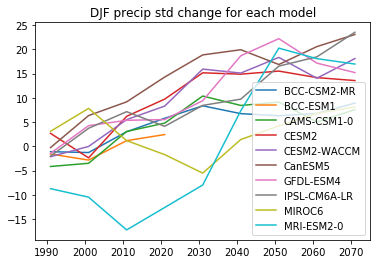

In [40]:
plt.plot((dsdG_djf_new-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(dsdG_djf_new.columns)